# REIT

- MSCI US REIT Custom Capped Index (BBRE)
- IFGL

In [1]:
import sys
import os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import polars as pl
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
from dividends_reinvestment_return import dividends_reinvestment_return

In [2]:
path = '../../../data/row/usd_jpy_rate.csv'
usd_jpy_rate = pl.read_csv(path)
usd_jpy_rate = usd_jpy_rate.with_columns(
    pl.col('date').cast(pl.Date)
).rename(
    {'date': 'Date'}
).drop_nulls()
usd_jpy_rate.head()

Date,usd_jpy_rate
date,f64
1973-01-04,301.1
1973-01-05,301.15
1973-01-08,302.25
1973-01-09,302.4
1973-01-10,301.55


## BBRE

In [25]:
ticker = 'BBRE'
tiskers = yf.Ticker(ticker)
historical_data = tiskers.history(period='max')

def get_close_and_dividends(data):
    df = pl.DataFrame({
        'Date': data.index,
        'Close': data['Close'],
        'Dividends': data['Dividends'],
    })
    return df


df = get_close_and_dividends(historical_data)
df = df.with_columns(pl.col('Date').cast(pl.Date)).join(usd_jpy_rate, on='Date', how='inner')
df = df.with_columns(
    (pl.col('Close') * pl.col('usd_jpy_rate')).alias('Close')
)
df = dividends_reinvestment_return(df, initial_shares=10000)

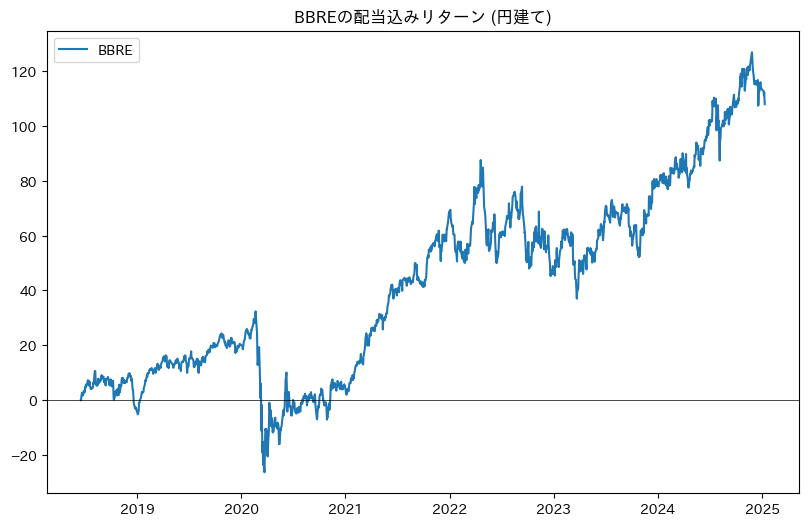

In [28]:
fig, ax = plt.subplots(figsize=(1.618*6, 6))
ax.plot(df['Date'], df['Return'], label=f'{ticker}')
ax.axhline(0, color='black', linewidth=0.5)
ax.set_title(f'{ticker}の配当込みリターン (円建て)')
ax.legend()

In [27]:
cagr = (df['Value'][-1] / df['Value'][0]) ** (250 / len(df)) - 1

sd = np.std(df['Close'].log().diff().fill_null(0).to_numpy())
sd_yearly = sd * np.sqrt(250)

sr = cagr / sd_yearly

print(f'CAGR: {cagr:.3%}')
print(f'Volatility: {sd_yearly:.3%}')
print(f'Sharpe Ratio: {sr:.3f}')

CAGR: 12.560%
Volatility: 26.526%
Sharpe Ratio: 0.473


## IFGL

In [29]:
ticker = 'IFGL'
tiskers = yf.Ticker(ticker)
historical_data = tiskers.history(period='max')

def get_close_and_dividends(data):
    df = pl.DataFrame({
        'Date': data.index,
        'Close': data['Close'],
        'Dividends': data['Dividends'],
    })
    return df


df = get_close_and_dividends(historical_data)
df = df.with_columns(pl.col('Date').cast(pl.Date)).join(usd_jpy_rate, on='Date', how='inner')
df = df.with_columns(
    (pl.col('Close') * pl.col('usd_jpy_rate')).alias('Close')
)
df = dividends_reinvestment_return(df, initial_shares=10000)

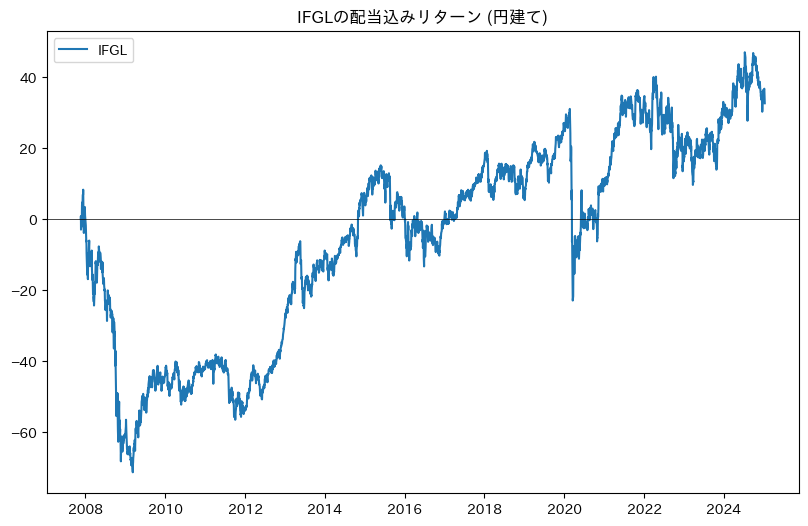

In [31]:
fig, ax = plt.subplots(figsize=(1.618*6, 6))
ax.plot(df['Date'], df['Return'], label=f'{ticker}')
ax.axhline(0, color='black', linewidth=0.5)
ax.set_title(f'{ticker}の配当込みリターン (円建て)')
ax.legend()

In [24]:
cagr = (df['Value'][-1] / df['Value'][0]) ** (250 / len(df)) - 1

sd = np.std(df['Close'].log().diff().fill_null(0).to_numpy())
sd_yearly = sd * np.sqrt(250)

sr = cagr / sd_yearly

print(f'CAGR: {cagr:.3%}')
print(f'Volatility: {sd_yearly:.3%}')
print(f'Sharpe Ratio: {sr:.3f}')

CAGR: 1.760%
Volatility: 25.122%
Sharpe Ratio: 0.070


## 比較

In [175]:
ticker = ['BBRE', 'IFGL', 'JPY=X']
tiskers = yf.Tickers(ticker)
historical_data = tiskers.history(period='max')
historical_data.dropna(inplace=True)

def get_close_and_dividends(data, ticker):
    df = pl.DataFrame({
            'Date': data.index,
            'Close': data['Close'][f'{ticker}'] * data['Close'][f'JPY=X'],
            'Dividends': data['Dividends'][f'{ticker}'] * data['Close'][f'JPY=X'],
    })
    return df

df = pl.DataFrame({
    'Date': historical_data.index,
    'BBRE_close': historical_data['Close']['BBRE'] * historical_data['Close']['JPY=X'],
    'BBRE_dividends': historical_data['Dividends']['BBRE'] * historical_data['Close']['JPY=X'],
    'IFGL_close': historical_data['Close']['IFGL'] * historical_data['Close']['JPY=X'],
    'IFGL_dividends': historical_data['Dividends']['IFGL'] * historical_data['Close']['JPY=X'],
})

bbre = get_close_and_dividends(historical_data, ticker='BBRE')
bbre = bbre.with_columns(pl.col('Date').cast(pl.Date)).join(usd_jpy_rate, on='Date', how='inner')
bbre = bbre.with_columns(
    (pl.col('Close') * pl.col('usd_jpy_rate')).alias('Close')
)
bbre = dividends_reinvestment_return(bbre, initial_shares=10000)

ifgl = get_close_and_dividends(historical_data, ticker='IFGL')
ifgl = ifgl.with_columns(pl.col('Date').cast(pl.Date)).join(usd_jpy_rate, on='Date', how='inner')
ifgl = ifgl.with_columns(
    (pl.col('Close') * pl.col('usd_jpy_rate')).alias('Close')
)
ifgl = dividends_reinvestment_return(ifgl, initial_shares=10000)

[*********************100%***********************]  3 of 3 completed


In [351]:
df

Date,BBRE_close,BBRE_dividends,IFGL_close,IFGL_dividends
datetime[ns],f64,f64,f64,f64
2018-06-18 00:00:00,6878.299923,0.0,2564.174387,0.0
2018-06-19 00:00:00,6883.980051,0.0,2530.35107,44.826166
2018-06-20 00:00:00,6943.410672,0.0,2537.445484,0.0
2018-06-21 00:00:00,6991.203828,0.0,2536.998077,0.0
2018-06-22 00:00:00,7039.399525,0.0,2546.775906,0.0
…,…,…,…,…
2025-01-27 00:00:00,14933.047113,0.0,3091.518525,0.0
2025-01-28 00:00:00,14686.921588,0.0,3059.452682,0.0
2025-01-29 00:00:00,14541.656379,0.0,3075.401615,0.0


In [357]:
# 初期値
init_val = 100000
# BBREのリバランス区間
bbre_max_rate = 0.25
bbre_min_rate = 0.15

bbre_shares = []
bbre_navs = []
bbre_weights = []
ifgl_shares = []
ifgl_navs = []
total_navs = []
cashes = []

# 初日のポートフォリオ
bbre_init_share = init_val * bbre_max_rate // df['BBRE_close'][0]
bbre_shares.append(bbre_init_share)
bbre_init_nav = bbre_init_share * df['BBRE_close'][0]
bbre_navs.append(bbre_init_nav)
ifgl_init_share = (init_val - bbre_init_nav) // df['IFGL_close'][0]
ifgl_shares.append(ifgl_init_share)
ifgl_init_nav = ifgl_init_share * df['IFGL_close'][0]
ifgl_navs.append(ifgl_init_nav)
total_init_nav = bbre_init_nav + ifgl_init_nav
total_navs.append(total_init_nav)
bbre_weights.append(bbre_init_nav / total_init_nav)
cashes.append(init_val - total_init_nav)

for i in range(1, len(df)):
    # 配当金 (前日の持ち株数 * 配当金)
    bbre_dividends = bbre_shares[i-1] * df['BBRE_dividends'][i]
    ifgl_dividends = ifgl_shares[i-1] * df['IFGL_dividends'][i]
    # 前期のキャッシュと配当金を合算
    cash = cashes[i-1] + bbre_dividends + ifgl_dividends
    # BBREをいくつ買えるか
    bbre_share_cash = cash // df['BBRE_close'][i]
    # BBREを買ったあとのキャッシュ
    cash_for_bbre = bbre_share_cash * df['BBRE_close'][i]
    # IFGLをいくつ買えるか
    ifgl_share_cash = cash_for_bbre // df['IFGL_close'][i]
    # IFGLを買ったあとのキャッシュ
    cash_for_ifgl = ifgl_share_cash * df['IFGL_close'][i]
    cashes.append(cash_for_ifgl)
    # 配当再投資 (前日の持ち株数に配当金 / 終値を追加)
    bbre_share_re_inv = bbre_shares[i-1] + cash // df['BBRE_close'][i]
    ifgl_share_re_inv = ifgl_shares[i-1] + cash // df['IFGL_close'][i]
    # 評価額
    bbre_nav = bbre_share_re_inv * df['BBRE_close'][i]
    ifgl_nav = ifgl_share_re_inv * df['IFGL_close'][i]
    total_nav = bbre_nav + ifgl_nav
    # BBREのウェイト
    bbre_weight = bbre_nav / total_nav
    # BBREのウェイトが区間を外れた場合
    if bbre_weight > bbre_max_rate or bbre_weight < bbre_min_rate:
        print(f'rebalance at {df["Date"][i]}')
        print(f'BBRE weight: {bbre_weight:.2%}')
        print(f'---')
        # BBREのリバランス後の持ち株数
        bbre_share_r = total_nav * bbre_max_rate // df['BBRE_close'][i]
        bbre_shares.append(bbre_share_r)
        # BBREのリバランス後のNAV
        bbre_nav_r = bbre_share_r * df['BBRE_close'][i]
        bbre_navs.append(bbre_nav_r)
        # 売却数 (前回-今回)
        bbre_num_of_sells = bbre_share_re_inv - bbre_share_r
        # 売却益
        bbre_return = bbre_num_of_sells * df['BBRE_close'][i]
        # 新しくIFGLを買うための資金はBBREの売却益
        ifgl_share_new = bbre_return // df['IFGL_close'][i]
        # IFGLのリバランス後の持ち株数
        ifgl_share_r = ifgl_share_re_inv + ifgl_share_new
        ifgl_shares.append(ifgl_share_r)
        # IFGLのリバランス後のNAV
        ifgl_nav_r = ifgl_share_r * df['IFGL_close'][i]
        ifgl_navs.append(ifgl_nav_r)
        # リバランス後の総NAV
        total_nav = bbre_nav_r + ifgl_nav_r
        total_navs.append(total_nav)
        # BBREのウェイト
        bbre_weight_r = bbre_nav_r / total_nav
        bbre_weights.append(bbre_weight_r)

    # BBREのウェイトが15%以上25%以下の場合
    else:
        bbre_shares.append(bbre_share_re_inv)
        bbre_navs.append(bbre_nav)
        ifgl_shares.append(ifgl_share_re_inv)
        ifgl_navs.append(ifgl_nav)
        total_navs.append(total_nav)
        bbre_weights.append(bbre_weight)

rebalance_df = pl.DataFrame({
    'Date': df['Date'],
    'BBRE_shares': bbre_shares,
    'BBRE_navs': bbre_navs,
    'IFGL_shares': ifgl_shares,
    'IFGL_navs': ifgl_navs,
    'Total_navs': total_navs,
    'BBRE_weights': bbre_weights,
})

rebalance_df = rebalance_df.with_columns([
    pl.col('Total_navs').log().alias('Total_navs_log'),
])
rebalance_df = rebalance_df.with_columns([
    (pl.col('Total_navs_log') - rebalance_df['Total_navs_log'][0]).alias('LogReturn'),
])
rebalance_df = rebalance_df.with_columns([
    ((pl.col('LogReturn').exp() - 1)*100).alias('Return'),
])

rebalance at 2021-11-02 00:00:00
BBRE weight: 25.22%
---


In [358]:
rebalance_df

Date,BBRE_shares,BBRE_navs,IFGL_shares,IFGL_navs,Total_navs,BBRE_weights,Total_navs_log,LogReturn,Return
datetime[ns],f64,f64,f64,f64,f64,f64,f64,f64,f64
2018-06-18 00:00:00,3.0,20634.899769,30.0,76925.231601,97560.13137,0.21151,11.488224,0.0,0.0
2018-06-19 00:00:00,3.0,20651.940154,31.0,78440.883156,99092.82331,0.20841,11.503812,0.015588,1.571023
2018-06-20 00:00:00,3.0,20830.232017,31.0,78660.80999,99491.042007,0.209368,11.507823,0.019599,1.979201
2018-06-21 00:00:00,3.0,20973.611485,31.0,78646.940398,99620.551883,0.210535,11.509124,0.0209,2.111949
2018-06-22 00:00:00,3.0,21118.198576,31.0,78950.053072,100068.251648,0.211038,11.513608,0.025384,2.570846
…,…,…,…,…,…,…,…,…,…
2025-01-27 00:00:00,2.0,29866.094227,35.0,108203.148369,138069.242596,0.216312,11.835511,0.347286,41.522198
2025-01-28 00:00:00,2.0,29373.843175,35.0,107080.843887,136454.687063,0.215264,11.823748,0.335524,39.867265
2025-01-29 00:00:00,2.0,29083.312757,35.0,107639.056512,136722.369269,0.212718,11.825708,0.337483,40.141641


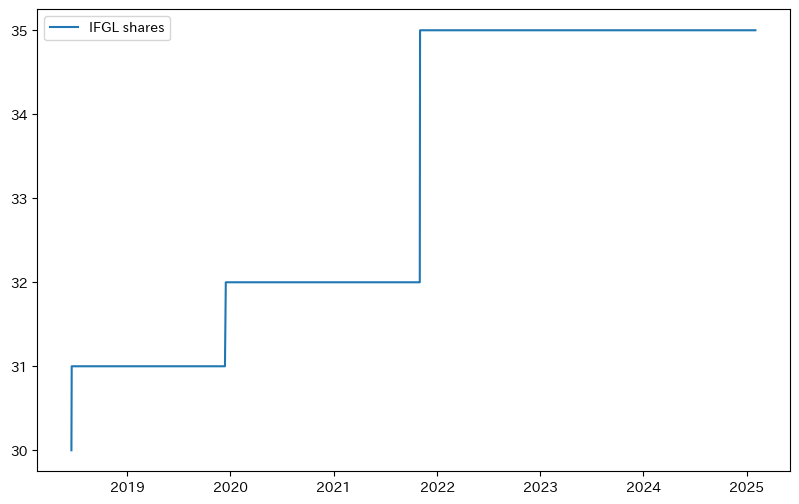

In [359]:
fig, ax = plt.subplots(figsize=(1.618*6, 6))
ax.plot(rebalance_df['Date'], rebalance_df['IFGL_shares'], label='IFGL shares')
ax.legend()

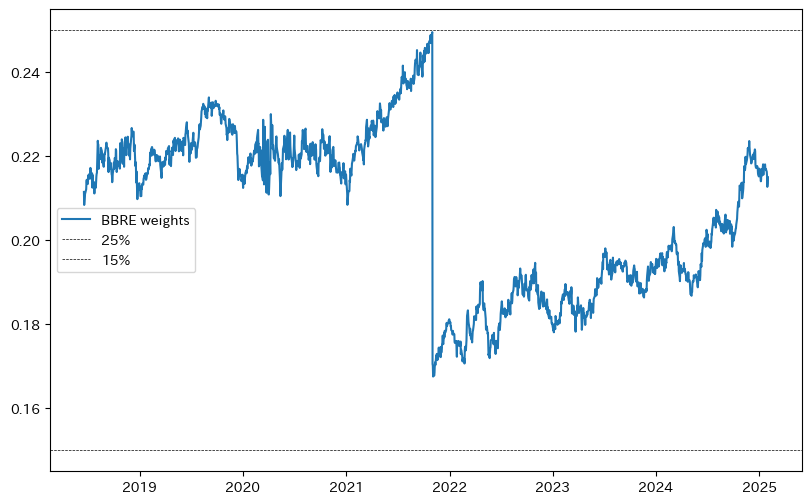

In [360]:
fig, ax = plt.subplots(figsize=(1.618*6, 6))
ax.plot(rebalance_df['Date'], rebalance_df['BBRE_weights'], label='BBRE weights')
ax.axhline(bbre_max_rate, color='black', linewidth=0.5, linestyle='--', label=f'{bbre_max_rate:.0%}')
ax.axhline(bbre_min_rate, color='black', linewidth=0.5, linestyle='--', label=f'{bbre_min_rate:.0%}')
ax.legend()

In [361]:
buy_and_hold = pl.DataFrame({
    'Date': df['Date'],
    'BBRE_navs': df['BBRE_close']*bbre_init_share,
    'IFGL_navs': df['IFGL_close']*ifgl_init_share,
    'Total_navs': df['BBRE_close']*bbre_init_share + df['IFGL_close']*ifgl_init_share,
})
buy_and_hold = buy_and_hold.with_columns([
    pl.col('Total_navs').log().alias('Total_navs_log'),
])
buy_and_hold = buy_and_hold.with_columns([
    (pl.col('Total_navs_log') - buy_and_hold['Total_navs_log'][0]).alias('LogReturn'),
])
buy_and_hold = buy_and_hold.with_columns([
    ((pl.col('LogReturn').exp() - 1)*100).alias('Return'),
])

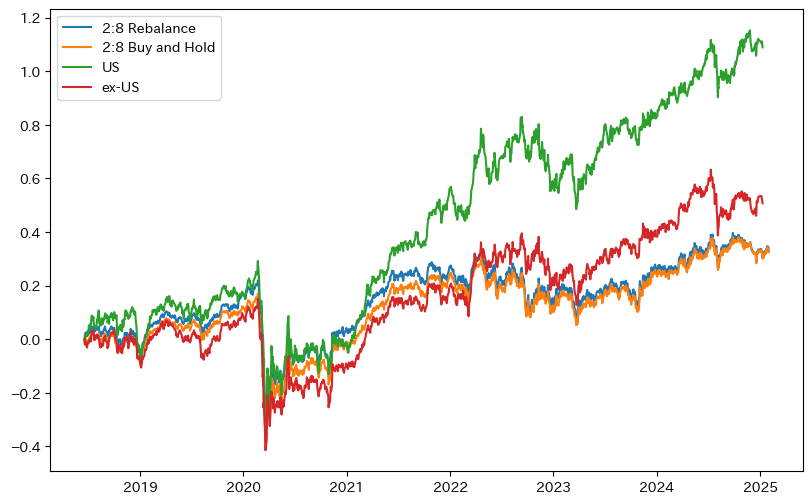

In [362]:
bbre_init_nav_log = np.log(bbre_init_nav)
ifgl_init_nav_log = np.log(ifgl_init_nav)

fig, ax = plt.subplots(figsize=(1.618*6, 6))
ax.plot(rebalance_df['Date'], rebalance_df['LogReturn'], label='2:8 Rebalance')
ax.plot(rebalance_df['Date'], buy_and_hold['LogReturn'], label='2:8 Buy and Hold')
ax.plot(bbre['Date'], bbre['LogReturn'], label='US')
ax.plot(ifgl['Date'], ifgl['LogReturn'], label='ex-US')
ax.legend()

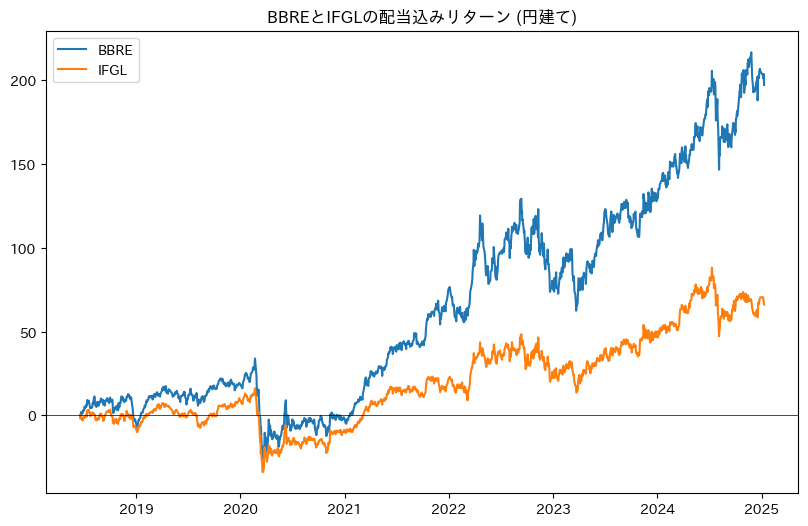

In [190]:
fig, ax = plt.subplots(figsize=(1.618*6, 6))
ax.plot(bbre['Date'], bbre['Return'], label='BBRE')
ax.plot(ifgl['Date'], ifgl['Return'], label='IFGL')
ax.axhline(0, color='black', linewidth=0.5)
ax.set_title('BBREとIFGLの配当込みリターン (円建て)')
ax.legend()

## Volatility

In [20]:
volatility_df = df.select([
    pl.col("us_reit_log_diff"),
    pl.col("ex_us_reit_log_diff"),
])

ColumnNotFoundError: us_reit_log_diff

Resolved plan until failure:

	---> FAILED HERE RESOLVING 'select' <---
DF ["Date", "Close", "Dividends", "usd_jpy_rate"]; PROJECT */9 COLUMNS; SELECTION: None

In [60]:
volatility_df

us_reit_log_diff,ex_us_reit_log_diff
f64,f64
0.0,0.0
0.005165,0.008622
0.009205,-0.014152
0.00431,-0.002726
0.010501,0.007478
…,…
-0.000779,0.0
0.019836,0.014411
-0.017969,-0.011822


In [57]:
volatility_df.std() * np.sqrt(252)

us_reit_log_diff,ex_us_reit_log_diff
f64,f64
0.240079,0.185878


$$
\text{variance} = w^{\top} \cdot \Sigma \cdot w
$$

- $w$: weight
- $\Sigma$: covariance matrix

In [90]:
from scipy.optimize import minimize

num_assets = 2

tmp = np.array([volatility_df['us_reit_log_diff'], volatility_df['ex_us_reit_log_diff']])
cov_matrix = np.cov(tmp)

def portfolio_variance(weights):
    var = weights.T @ cov_matrix @ weights
    return np.sqrt(var) * np.sqrt(252)

def constraint_sum_of_weights(weights):
    return np.sum(weights) - 1

constraints = [
    {"type": "eq", "fun": constraint_sum_of_weights}
]

initial_guess = np.ones(num_assets) / num_assets

bounds = [(0, 1) for _ in range(num_assets)]

result = minimize(portfolio_variance, initial_guess, constraints=constraints, bounds=bounds)

print(f"Optimal portfolio variance: {result.fun:.3%}")
print("Optimal portfolio weights")
print(f'BBRE: {result.x[0]:.2%}, IFGL: {result.x[1]:.2%}')

Optimal portfolio variance: 18.502%
Optimal portfolio weights
BBRE: 10.50%, IFGL: 89.50%
